# FNO for virtual damage sensor

In [1]:
# packages
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path
from nopkit.data import load_damage_sensor_dataset
from nopkit.mask import MaskGenerator
from nopkit.plot import data_image, pred_plot, pred_anim

device = 'cuda'

c:\workspace\no_playground\neuralop-playground\nopkit_pkg\nopkit\mask.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.masks = torch.tensor(mask_list, dtype=torch.float32) # (n_masks, height, width)


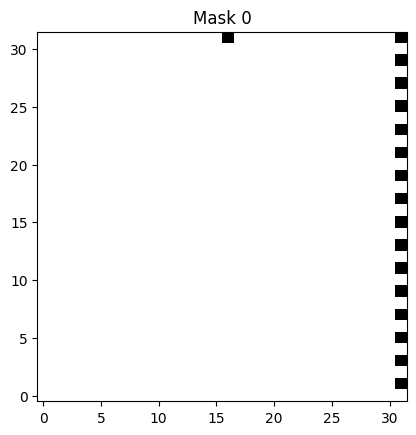

In [29]:
# Using Saikat's mask
gen = MaskGenerator(grid_shape=(32, 32))

pos = [
    (31, 16),
    (1, 31), (3, 31), (5, 31), (7, 31), (9, 31), (11, 31), (13, 31), (15, 31),
    (17, 31), (19, 31), (21, 31), (23, 31), (25, 31), (27, 31), (29, 31), (31, 31)
]
masks = gen.generate_from_positions([pos])
gen.plot()
gen.save("../data/damage_sensor/mask_saikat.pt")

In [2]:
# load data
data_dir = Path("../data/damage_sensor")

train_loader, test_loaders, data_processor = load_damage_sensor_dataset(
    ramps_path=data_dir / "ramps_n500_res32.pt",
    damage_path=data_dir / "damage_n500_t175_res32.pt",
    defgrad_path=data_dir / "defgrad_n500_t175_res32.pt",
    elec_path=data_dir / "elec_n500_t175_res32.pt",
    masks_path=data_dir / "mask_saikat.pt",
    n_train=450,
    batch_size=10,
    test_batch_sizes=[10],
    test_resolutions=[32],
    encode_input=True,
    encode_output=True,
    # encoding="channel-wise",
    # channel_dim=1,
)
data_processor = data_processor.to(device)
# print("Input encoder:", data_processor.in_normalizer)
# print("Output encoder:", data_processor.out_normalizer)
# print("in_normalizer mean:", getattr(data_processor.in_normalizer, "mean", None))
# print("out_normalizer mean:", getattr(data_processor.out_normalizer, "mean", None))

c:\workspace\no_playground\neuralop-playground\nopkit_pkg\nopkit\data.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ramps = torch.load(ramps_path)      # shape (n_sa

Loaded RAMPs      -> ..\data\damage_sensor\ramps_n500_res32.pt,	(torch.Size([500, 32, 32]))
Loaded damage     -> ..\data\damage_sensor\damage_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded defgrad    -> ..\data\damage_sensor\defgrad_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded elec field -> ..\data\damage_sensor\elec_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded masks      -> ..\data\damage_sensor\mask_saikat.pt,	(torch.Size([1, 32, 32]))
Loading total samples: 500, total masks: 1
Loading train db: 450 samples, test db: 50 samples
Train input shape: torch.Size([450, 3, 32, 32, 175]), Train output shape: torch.Size([450, 3, 32, 32, 175])
Test input shape: torch.Size([50, 3, 32, 32, 175]), Test output shape: torch.Size([50, 3, 32, 32, 175])


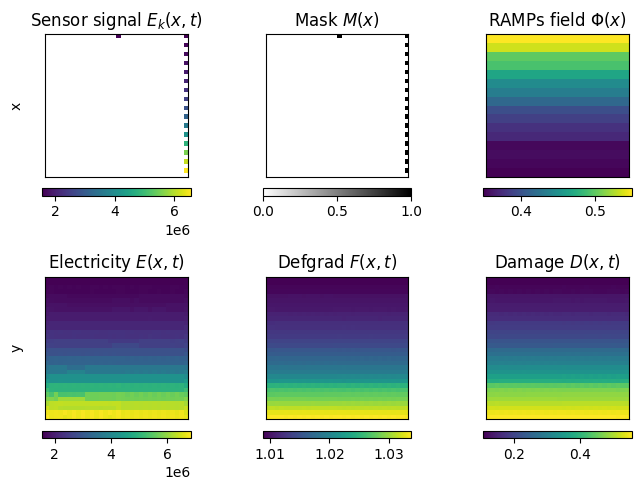

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [14]:
# check data
index = 5
x = train_loader.dataset[index]['x']
y = train_loader.dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

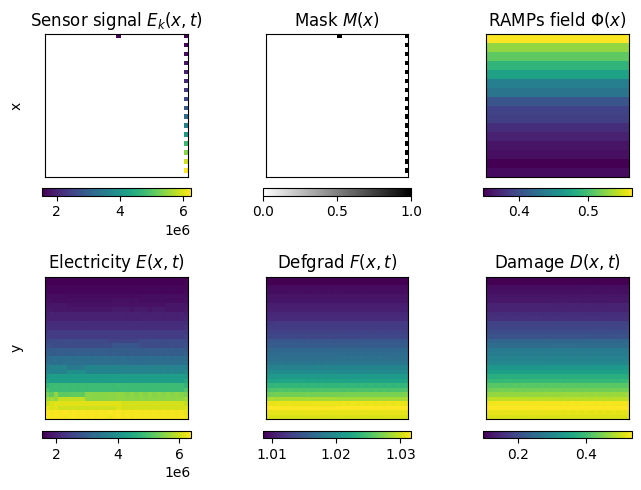

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [15]:
# check data
index = 49
x = test_loaders[32].dataset[index]['x']
y = test_loaders[32].dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

In [5]:
# config model
model = FNO(
    n_modes=(8,8,10),
    in_channels=3,
    out_channels=3,
    hidden_channels=64,
    n_layers=4,
    projection_channel_ratio=2,
    positional_embedding = 'grid'
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 12634435 parameters.


In [6]:
epochs=10
learning_rate=5e-4
scheduler_step=10
scheduler_gamma=0.5

# training setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step, gamma=scheduler_gamma
)

# losses setup
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 8, 8, 6]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(6, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d

In [7]:
# %%capture out
trainer = Trainer(
    model=model,
    n_epochs=epochs,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=1,
    log_output=False,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=1,
    save_dir="./ckpt/fno3d_cuda/"
)

Training on 450 samples
Testing on [50] samples         on resolutions [32].
Raw outputs of shape torch.Size([10, 3, 32, 32, 175])
[0] time=520.14, avg_loss=77.2163, train_err=772.1626
Eval: 32_h1=22.9171, 32_l2=23.0974
[Rank 0]: saved training state to ./ckpt/fno3d_cuda/
[1] time=537.51, avg_loss=12.7552, train_err=127.5517
Eval: 32_h1=4.8135, 32_l2=16.2325
[Rank 0]: saved training state to ./ckpt/fno3d_cuda/
[2] time=538.59, avg_loss=4.7792, train_err=47.7919
Eval: 32_h1=3.0609, 32_l2=12.6079
[Rank 0]: saved training state to ./ckpt/fno3d_cuda/
[3] time=537.22, avg_loss=3.8101, train_err=38.1012
Eval: 32_h1=2.6751, 32_l2=7.0541
[Rank 0]: saved training state to ./ckpt/fno3d_cuda/
[4] time=532.19, avg_loss=3.0765, train_err=30.7653
Eval: 32_h1=2.0527, 32_l2=4.1986
[Rank 0]: saved training state to ./ckpt/fno3d_cuda/
[5] time=541.15, avg_loss=2.7280, train_err=27.2796
Eval: 32_h1=2.2886, 32_l2=3.8613
[Rank 0]: saved training state to ./ckpt/fno3d_cuda/
[6] time=535.26, avg_loss=2.5524,

{'train_err': 23.22331860860189,
 'avg_loss': 2.3223318608601886,
 'avg_lasso_loss': None,
 'epoch_train_time': 510.3961545000002,
 '32_h1': tensor(1.7700, device='cuda:0'),
 '32_l2': tensor(3.1023, device='cuda:0')}

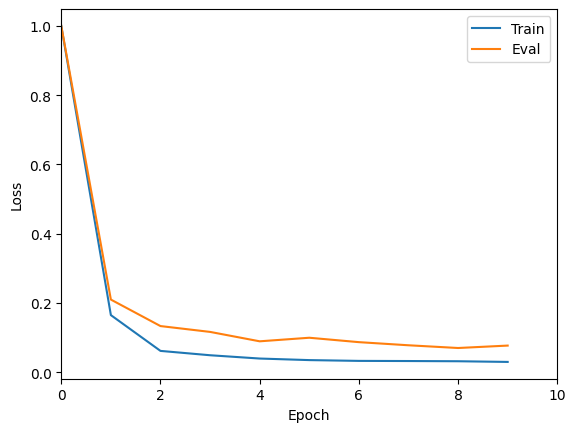

In [3]:
# plot train and eval loss
import re
import matplotlib.pyplot as plt

with open("log.txt", 'r') as f:
    log = f.read()

train_loss = [float(x) for x in re.findall(r"avg_loss=([0-9.]+)", log)]
eval_loss = [float(x) for x in re.findall(r"32_h1=([0-9.]+)", log)]

train_loss_rel = [x / train_loss[0] for x in train_loss]
eval_loss_rel = [x / eval_loss[0] for x in eval_loss]

# plot
fig, ax = plt.subplots()
ax.plot(train_loss_rel, label='Train')
ax.plot(eval_loss_rel, label='Eval')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set(xlim=[0, len(train_loss)])
ax.legend()
plt.show()

In [15]:
model.save_checkpoint("./model", save_name="fno3d_cuda")

In [3]:
# reload
model_reload = FNO.from_checkpoint("./model", save_name="fno3d_cuda")

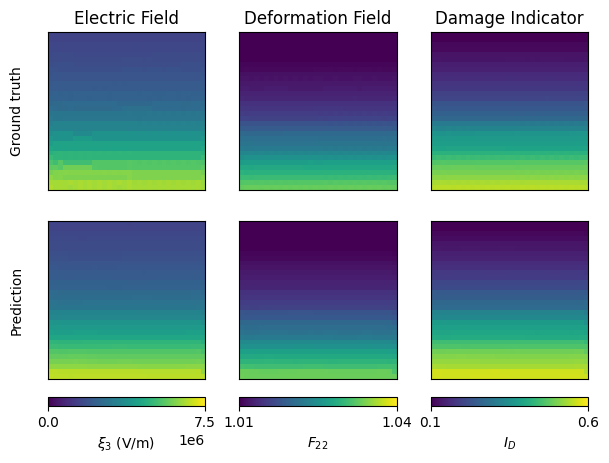

(array([[<Axes: title={'center': 'Electric Field'}>,
         <Axes: title={'center': 'Deformation Field'}>,
         <Axes: title={'center': 'Damage Indicator'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object),
  <matplotlib.image.AxesImage at 0x27f69e04490>])

In [4]:
# plot prediction
# model_use = model
model_use = model_reload.to(device)

test_samples = test_loaders[32].dataset
idx = 10

data = test_samples[idx]

data_processor.to(device)
data_processor.eval()
data = data_processor.preprocess(data, batched=True)


x = data['x']
y = data['y']
out = model_use(x)

# postprocess data
out, _ = data_processor.postprocess(out, data)

t = -1

vmins = [2e-6, 1.01, 0.1]
vmaxs = [7.5e6, 1.04, 0.6]
pred_plot(y.cpu(), out.squeeze().detach().cpu().numpy(), t=t, 
           show_colorbar=True, vmins=vmins, vmaxs=vmaxs, plot_method='image')

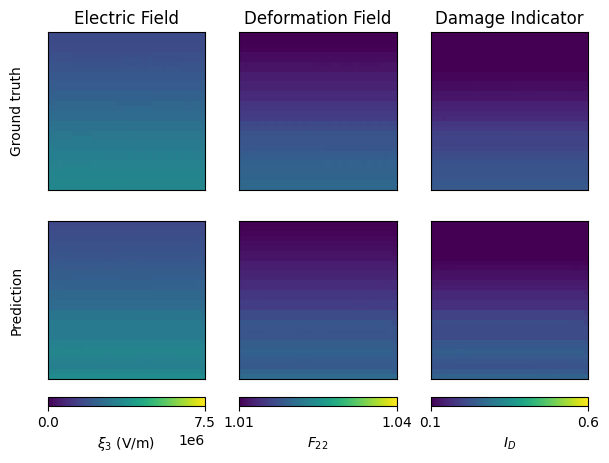

save to ./media/mask_id10.gif


In [4]:
# plot prediction
# model_use = model
model_use = model_reload.to(device)

test_samples = test_loaders[32].dataset
idx = 10

data = test_samples[idx]

data_processor.to(device)
data_processor.eval()
data = data_processor.preprocess(data, batched=True)


x = data['x']
y = data['y']
out = model_use(x)

# postprocess data
out, _ = data_processor.postprocess(out, data)

t_range = range(150, 175, 1)

vmins = [2e-6, 1.01, 0.1]
vmaxs = [7.5e6, 1.04, 0.6]

save_path = f'./media/mask_id{idx}.gif'
pred_anim(y.cpu(), out.squeeze().detach().cpu().numpy(), t_range=t_range,
          save_path=save_path, fps=2,
          show_colorbar=True, vmins=vmins, vmaxs=vmaxs, plot_method='image')